In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler, Normalizer, QuantileTransformer, PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import timeit
import csv
from matplotlib import pyplot as plt

**Khởi tạo bộ scalers**

In [2]:
# Standardization techniques
scalers = [MinMaxScaler(), MaxAbsScaler(), StandardScaler(), RobustScaler(), Normalizer(), QuantileTransformer(), PowerTransformer()]

**Khởi tạo bộ models thử nghiệm**

In [3]:
models = [LogisticRegression(random_state=42), LinearDiscriminantAnalysis()]
        #   , RandomForestClassifier(random_state=42)
        #   , DecisionTreeClassifier(random_state=42), XGBClassifier(random_state=42), GaussianNB(), GradientBoostingClassifier(random_state=42)] 

**Thử nghiệm để tìm ra thuật toán tối ưu cho bài toán**

In [4]:
def test(data):  
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    X = data.drop('team_win', axis=1)
    y = data['team_win']
    
    model_list = []

    # Loop through models and scalers
    for model in models:
        elapsed_time = {}
        acc_scores = {}
        for scaler in scalers:
            start_time = timeit.default_timer()
            acc = []
            
            # Scale the data
            X_scaled = scaler.fit_transform(X)
            
            # Loop through folds and calculate average accuracy
            for train_index, test_index in kf.split(X_scaled):
                X_train_scaled, X_test_scaled = X_scaled[train_index], X_scaled[test_index]
                y_train, y_test = y[train_index], y[test_index]
                
                # Train the model
                model.fit(X_train_scaled, y_train)
                
                # Make predictions on the testing data
                y_pred = model.predict(X_test_scaled)
                
                # Calculate the accuracy of the predictions
                acc.append(accuracy_score(y_test, y_pred))
            
            # Append the accuracy score to the list for this model and scaler
            model_name = f"{type(model).__name__} ({type(scaler).__name__})"
            acc_scores[model_name] = np.mean(acc)
            elapsed_time[model_name] = timeit.default_timer() - start_time
        
        best_model_name = max(acc_scores, key=acc_scores.get)
        model_list.append((best_model_name, acc_scores[best_model_name], elapsed_time[best_model_name]))
        
    sorted_models = sorted(model_list, key=lambda x: x[1], reverse=True)
    print("Models ranked by accuracy score:")
    for i, model in enumerate(sorted_models):
        print(f"{i+1}. {model[0]} - Accuracy: {model[1]*100:.4f}%, Elapsed Time: {model[2]:.4f}s")
    

In [5]:
data = pd.read_csv("data_fe_1000_part_1.csv")
test(data)
data = pd.read_csv("data_fe.csv")
test(data)

Models ranked by accuracy score:
1. LogisticRegression (QuantileTransformer) - Accuracy: 75.9000%, Elapsed Time: 0.0463s
2. LinearDiscriminantAnalysis (Normalizer) - Accuracy: 75.9000%, Elapsed Time: 0.0166s
Models ranked by accuracy score:
1. LogisticRegression (StandardScaler) - Accuracy: 76.2977%, Elapsed Time: 0.0739s
2. LinearDiscriminantAnalysis (PowerTransformer) - Accuracy: 76.2278%, Elapsed Time: 0.2173s


In [6]:
for i in range(10):
    filename = f"data_fe_1000_part_{i+1}.csv"
    data = pd.read_csv(filename)
    print(filename)
    test(data)


data_fe_1000_part_1.csv
Models ranked by accuracy score:
1. LogisticRegression (QuantileTransformer) - Accuracy: 75.9000%, Elapsed Time: 0.0431s
2. LinearDiscriminantAnalysis (Normalizer) - Accuracy: 75.9000%, Elapsed Time: 0.0171s
data_fe_1000_part_2.csv
Models ranked by accuracy score:
1. LogisticRegression (StandardScaler) - Accuracy: 76.7000%, Elapsed Time: 0.0242s
2. LinearDiscriminantAnalysis (QuantileTransformer) - Accuracy: 76.5000%, Elapsed Time: 0.0283s
data_fe_1000_part_3.csv
Models ranked by accuracy score:
1. LogisticRegression (MinMaxScaler) - Accuracy: 77.1000%, Elapsed Time: 0.0389s
2. LinearDiscriminantAnalysis (Normalizer) - Accuracy: 76.9000%, Elapsed Time: 0.0287s
data_fe_1000_part_4.csv
Models ranked by accuracy score:
1. LinearDiscriminantAnalysis (QuantileTransformer) - Accuracy: 75.2000%, Elapsed Time: 0.0348s
2. LogisticRegression (RobustScaler) - Accuracy: 74.9000%, Elapsed Time: 0.0360s
data_fe_1000_part_5.csv
Models ranked by accuracy score:
1. LogisticRegre

In [7]:
# for i in range(6):
#     filename = f"data_fe_5000_part_{i+1}.csv"
#     data = pd.read_csv(filename)
#     test(data)

In [8]:
# for i in range(5):
#     filename = f"data_fe_6000_part_{i+1}.csv"
#     data = pd.read_csv(filename)
#     test(data)

In [18]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score

models = [(QuantileTransformer(), LogisticRegression(random_state=42)), (QuantileTransformer(), LinearDiscriminantAnalysis())]
model_names = ["Logistic Regression", "LinearDiscriminantAnalysis"]
data = pd.read_csv("data_fe_1000_part_1.csv")
dfs = []
X = data.drop('team_win', axis=1)
y = data['team_win']
j = 0

X_cols = X.columns.tolist()

for i, model in enumerate(models):
    auc_scores = []
    X = model[0].fit_transform(X)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for j, (train_index, test_index) in enumerate(kf.split(X)):
        X_train_scaled, X_test_scaled = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if isinstance(model[1], LogisticRegression):
            clf = LogisticRegression(random_state=42)
        elif isinstance(model[1], LinearDiscriminantAnalysis):
            clf = LinearDiscriminantAnalysis()
        
        clf.fit(X_train_scaled, y_train)
                
        y_pred = clf.predict(X_test_scaled)

        # Predict the win probability for the test set
        win_prob = clf.predict_proba(X_test_scaled)[:, 1]

        # Convert win probability to win percentage
        win_percentages = win_prob * 100
        auc_score = roc_auc_score(y_test, win_prob)
        print(f"AUC score for model {model} fold {j} : {auc_score}")
        
        auc_scores.append(auc_score)

        X_test_df = pd.DataFrame(X_test_scaled, columns=X_cols)

        # Predict the results on the test set
        y_pred = clf.predict(X_test_df)

        data = []
        for k in range(len(X_test_df)):
            data.append({
                "blue_win_percentage": win_percentages[k],
                "red_win_percentage": 100 - win_percentages[k],
                "team_win": y_test.iloc[k],
                "team_pred": y_pred[k]
            })

        # Create a DataFrame from the list of dicts
        df = pd.DataFrame(data)

        # Save the results to a CSV file
        model_name = model_names[i]
        df.to_csv(f"1ksamples_{model_name}_part_{j}.csv", index=False)
    
    print(f"Mean AUC Score for model {model}: ", np.mean(auc_scores)


AUC score for model (QuantileTransformer(), LogisticRegression(random_state=42)) fold 0 : 0.8566666666666666
AUC score for model (QuantileTransformer(), LogisticRegression(random_state=42)) fold 1 : 0.8214249824138277
AUC score for model (QuantileTransformer(), LogisticRegression(random_state=42)) fold 2 : 0.8459000000000001
AUC score for model (QuantileTransformer(), LogisticRegression(random_state=42)) fold 3 : 0.8461846184618462
AUC score for model (QuantileTransformer(), LogisticRegression(random_state=42)) fold 4 : 0.8466496163682865
AUC score for model (QuantileTransformer(), LinearDiscriminantAnalysis()) fold 0 : 0.8569696969696969
AUC score for model (QuantileTransformer(), LinearDiscriminantAnalysis()) fold 1 : 0.8268515727062608
AUC score for model (QuantileTransformer(), LinearDiscriminantAnalysis()) fold 2 : 0.8443
AUC score for model (QuantileTransformer(), LinearDiscriminantAnalysis()) fold 3 : 0.8456845684568457
AUC score for model (QuantileTransformer(), LinearDiscrimin

In [ ]:
for i in range(5):
    # Load the data from the four CSV files
    data1 = pd.read_csv(f'1ksamples_Logistic Regression_part_{i}.csv')
    data2 = pd.read_csv(f'1ksamples_LinearDiscriminantAnalysis_part_{i}.csv')

    # Calculate the difference between the two prediction columns
    diff = abs(data1['blue_win_percentage'] - data2['blue_win_percentage'])

    # Calculate the mean of the difference
    mean_diff = diff.mean()

    # Print the mean difference
    print(f"Mean difference between predictions for part {i}: {mean_diff}%")


Mean difference between predictions for part 0: 3.4750743760510625%
Mean difference between predictions for part 1: 4.0757514913298305%
Mean difference between predictions for part 2: 4.075365782638616%
Mean difference between predictions for part 3: 4.28327931907127%
Mean difference between predictions for part 4: 4.097502654780393%


In [ ]:
for i in range(5):
    # Load the data from the four CSV files
    data1 = pd.read_csv(f'1ksamples_Logistic Regression_part_{i}.csv')
    data2 = pd.read_csv(f'1ksamples_LinearDiscriminantAnalysis_part_{i}.csv')

    y1 = data1['blue_win_percentage'].head(200)
    y2 = data2['blue_win_percentage'].head(200)

    # Create a list of x values from 0 to the length of y1
    x = list(range(len(y1)))

    plt.figure(figsize=(40, 6))

    # Plot the four lines on the same graph
    plt.plot(x, y1, label='Logistic Regression')
    plt.plot(x, y2, label='Random Forest')

    # Add a legend to the graph
    plt.legend()

    # Add labels for the x and y axis
    plt.xlabel('Game Number')
    plt.ylabel('Blue Win Percentage')

    # Show the graph
    plt.show()


NameError: name 'plt' is not defined

In [ ]:
import warnings
warnings.filterwarnings("ignore")

models = [(RobustScaler(), LogisticRegression(random_state=42)), (QuantileTransformer(), LinearDiscriminantAnalysis()) ]
model_names = ["Logistic Regression", "LinearDiscriminantAnalysis"]
data = pd.read_csv("data_fe.csv")
dfs = []
X = data.drop('team_win', axis=1)
y = data['team_win']
j = 0

X_cols = X.columns.tolist()

for i, model in enumerate(models):
    X = model[0].fit_transform(X)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for j, (train_index, test_index) in enumerate(kf.split(X)):
        X_train_scaled, X_test_scaled = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if isinstance(model[1], LogisticRegression):
            clf = LogisticRegression(random_state=42)
        elif isinstance(model[1], LinearDiscriminantAnalysis):
            clf = LinearDiscriminantAnalysis()
        
        clf.fit(X_train_scaled, y_train)
                
        y_pred = clf.predict(X_test_scaled)

        # Predict the win probability for the test set
        win_prob = clf.predict_proba(X_test_scaled)[:, 1]

        # Convert win probability to win percentage
        win_percentages = win_prob * 100

        X_test_df = pd.DataFrame(X_test_scaled, columns=X_cols)

        # Predict the results on the test set
        y_pred = clf.predict(X_test_df)

        data = []
        for k in range(len(X_test_df)):
            data.append({
                "gold_difference": X_test_df.iloc[k]["gold_difference"],
                "herald_difference": X_test_df.iloc[k]["herald_difference"],
                "dragon_difference": X_test_df.iloc[k]["dragon_difference"],
                "win_score_difference": X_test_df.iloc[k]["win_score_difference"],
                "turret_difference": X_test_df.iloc[k]["turret_difference"],
                "kda_difference_top": X_test_df.iloc[k]["kda_difference_top"],
                "kda_difference_jungle": X_test_df.iloc[k]["kda_difference_jungle"],
                "kda_difference_mid": X_test_df.iloc[k]["kda_difference_mid"],
                "kda_difference_ad": X_test_df.iloc[k]["kda_difference_ad"],
                "kda_difference_sp": X_test_df.iloc[k]["kda_difference_sp"],
                "blue_win_percentage": win_percentages[k],
                "red_win_percentage": 100 - win_percentages[k],
                "team_win": y_test[k]
            })

        # Create a DataFrame from the list of dicts
        df = pd.DataFrame(data)

        # Save the results to a CSV file
        model_name = model_names[i]
        df.to_csv(f"10ksamples_{model_name}_part_{j}.csv", index=False)


In [ ]:
for i in range(5):
    # Load the data from the four CSV files
    data1 = pd.read_csv(f'10ksamples_Logistic Regression_part_{i}.csv')
    data2 = pd.read_csv(f'10ksamples_LinearDiscriminantAnalysis_part_{i}.csv')

    # Calculate the difference between the two prediction columns
    diff = abs(data1['blue_win_percentage'] - data2['blue_win_percentage'])

    # Calculate the mean of the difference
    mean_diff = diff.mean()

    # Print the mean difference
    print(f"Mean difference between predictions for part {i}: {mean_diff}%")


Mean difference between predictions for part 0: 4.064340501311738%
Mean difference between predictions for part 1: 4.0246780664038635%
Mean difference between predictions for part 2: 4.0258484158442505%
Mean difference between predictions for part 3: 4.1598479891408084%
Mean difference between predictions for part 4: 4.046519071100356%


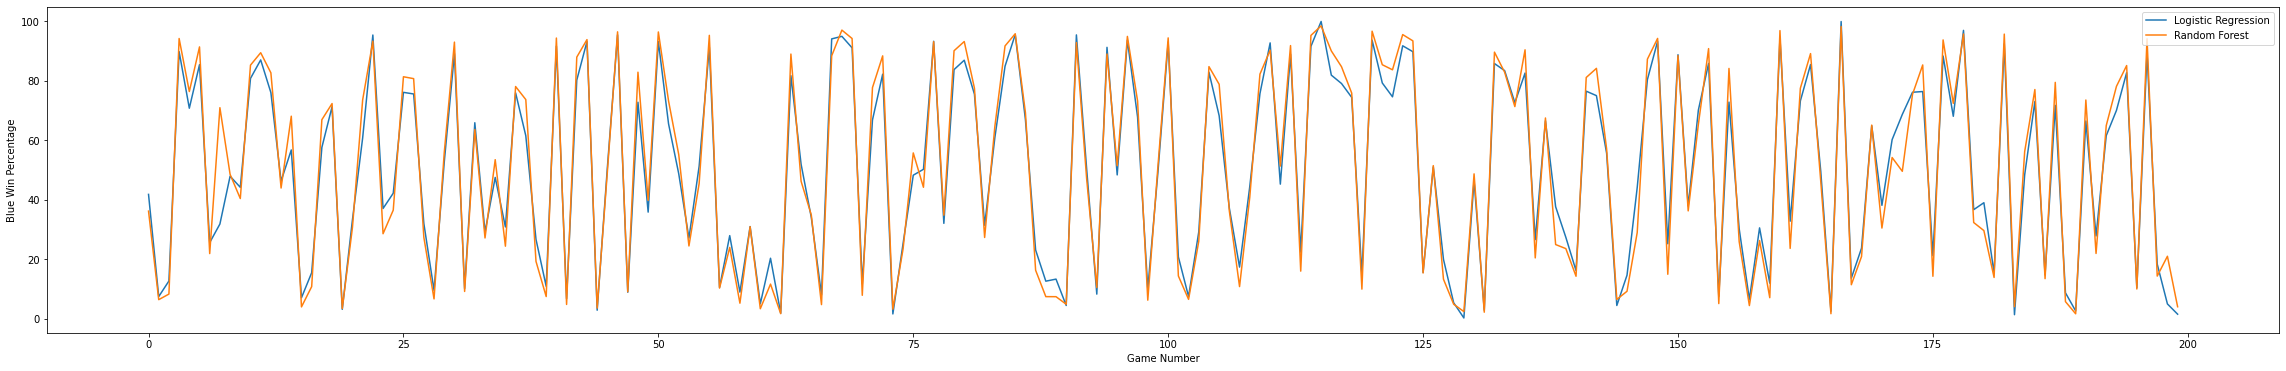

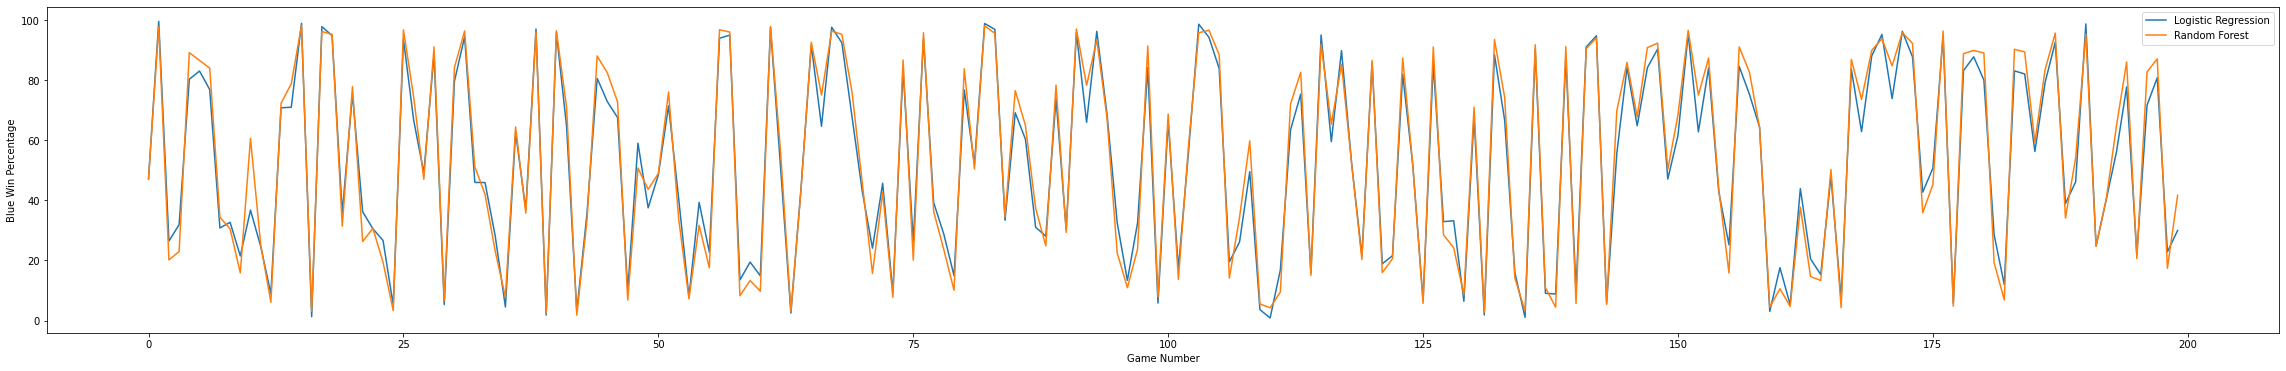

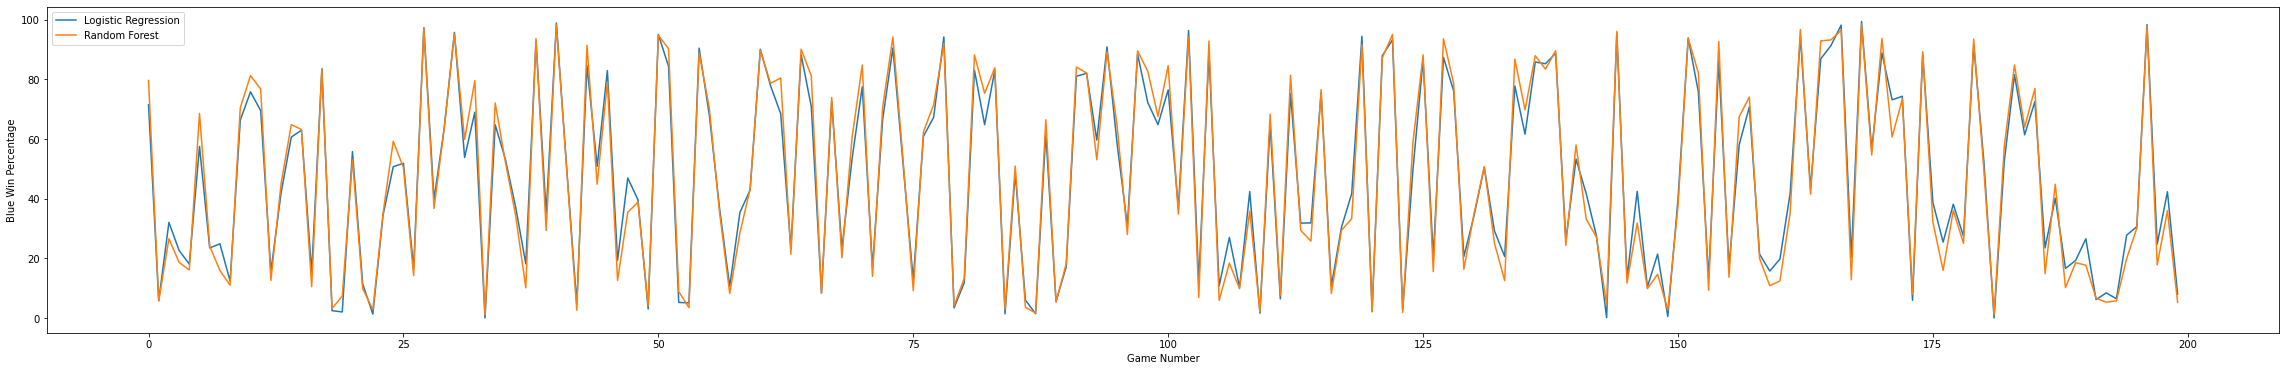

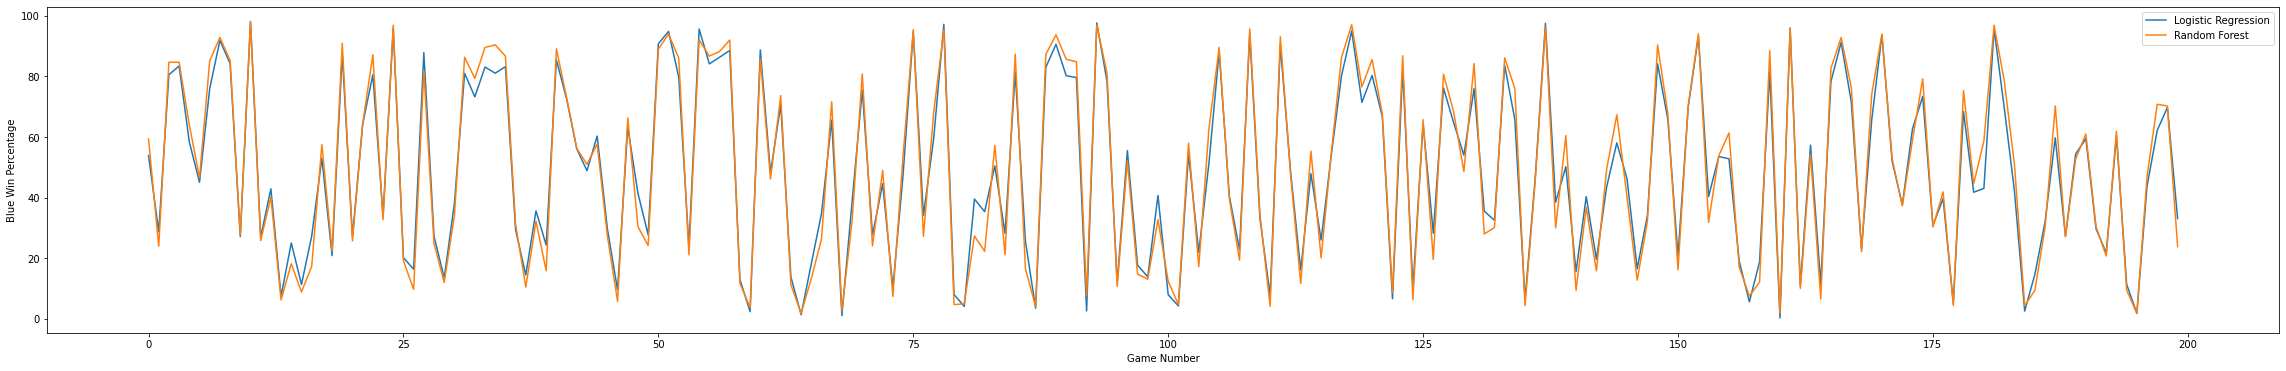

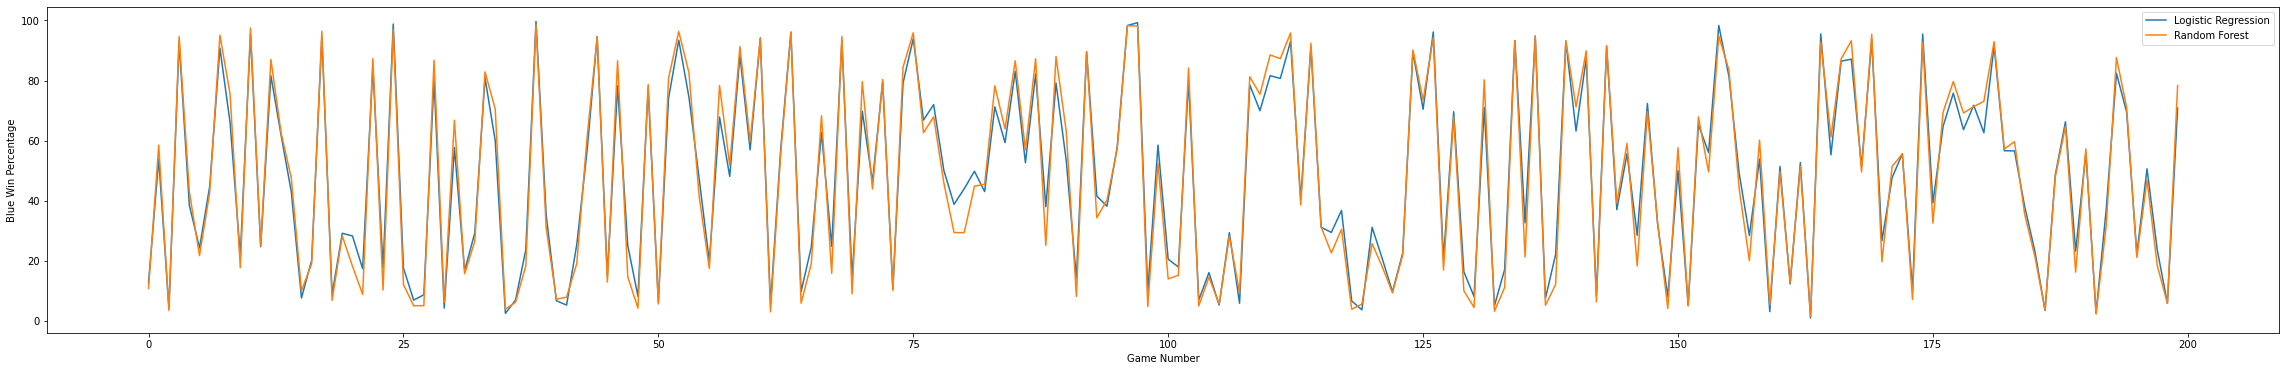

In [ ]:
for i in range(5):
    # Load the data from the four CSV files
    data1 = pd.read_csv(f'10ksamples_Logistic Regression_part_{i}.csv')
    data2 = pd.read_csv(f'10ksamples_LinearDiscriminantAnalysis_part_{i}.csv')

    y1 = data1['blue_win_percentage'].head(200)
    y2 = data2['blue_win_percentage'].head(200)

    # Create a list of x values from 0 to the length of y1
    x = list(range(len(y1)))

    plt.figure(figsize=(40, 6))

    # Plot the four lines on the same graph
    plt.plot(x, y1, label='Logistic Regression')
    plt.plot(x, y2, label='Random Forest')

    # Add a legend to the graph
    plt.legend()

    # Add labels for the x and y axis
    plt.xlabel('Game Number')
    plt.ylabel('Blue Win Percentage')

    # Show the graph
    plt.show()


In [ ]:
# Vẽ ROC curve
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

# Tính toán diện tích dưới ROC curve (AUC)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve = %0.2f" % roc_auc)